In [130]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

C:\Users\hanse\AppData\Local\Temp/ipykernel_16096/3724242927.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'sentiment'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,Tag,POS,Dep,Polarity,sentiment
0,15234,"[average, tax, refund]","[average, tax, refund]","[JJ, NN, NN]","[ADJ, NOUN, NOUN]","[AMOD, COMPOUND, NSUBJ]","[-0.16746922451155502, -0.45036036083636805, -...","[-1, -1, -1]"
1,12218,"[Believe, pulling, nighter, taxes, want, spend...","[believe, pull, nighter, taxis, want, spend, S...","[VB, VBG, NN, NNS, VBP, VBG, NNP]","[VERB, VERB, NOUN, NOUN, VERB, VERB, PROPN]","[ROOT, ADVCL, DOBJ, NSUBJ, CCOMP, XCOMP, POBJ]","[-0.076224116287831, -0.013437066753523, -0.00...","[-1, -1, -1, -1, -1, -1, -1]"
2,9308,"[undoubtedly, return, possibly, absorb, round]","[undoubtedly, return, possibly, absorb, round]","[RB, VB, RB, VB, JJ]","[ADV, VERB, ADV, VERB, ADJ]","[ADVMOD, ROOT, ADVMOD, ADVCL, POBJ]","[-0.008367406250114, -0.18449372532374603, -0....","[1, 1, 1, 1, 1]"
3,2361,[valuable],[valuable],[JJ],[ADJ],[AMOD],[-0.047267391108893005],[1]
4,9341,"[caught, Bauble, Bar, bug, priced, trendy, jew...","[catch, Bauble, Bar, bug, price, trendy, jewel...","[VBN, NNP, NNP, NN, VBN, JJ, NN, VB]","[VERB, PROPN, PROPN, NOUN, VERB, ADJ, NOUN, VERB]","[ADVCL, COMPOUND, COMPOUND, DOBJ, AMOD, AMOD, ...","[-0.046083002609461, 0.0008913010137260001, 0....","[1, 1, 1, 1, 1, 1, 1, 1]"


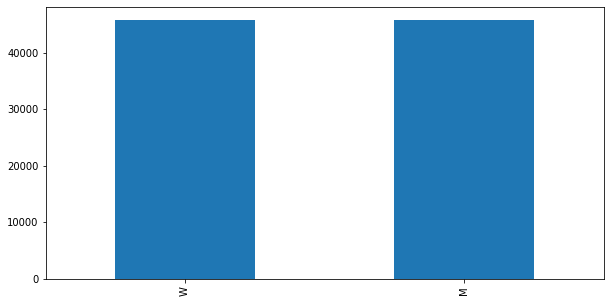

In [131]:
import pandas as pd

df = pd.read_json('../datasets/7_dataset_w_tags_SM.json')

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['sentiment'] = df.Gender.apply(lambda x: -1 if x == "M" else 1)
df = df.drop('Gender', axis=1)
df['Dep'] = df['Dep'].str.upper()
df = df.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'Tag', 'POS', 'Dep', 'Polarity', 'sentiment'].agg(lambda x: list(x))
df = df.sample(frac=1).reset_index(drop=True)

split = round(len(df)*0.6)
train_data = df[:split]
test_data = df[split:]

train_data.head(5)

In [132]:
# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 2, 
                                        restore_best_weights = True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)

root_logdir = os.path.join(os.curdir, "./logged_models/keras_words")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

In [133]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import numpy as np
import tensorflow as tf
tokenizer = Tokenizer(oov_token="<OOV>")

vocab_size = 40000
embedding_dim = 16
max_length = max([len(w) for w in train_data['Lemma']])
padding_type = 'post'
oov_tok = '<OOV>'
output_dim = 64

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['Lemma'])
word_index = tokenizer.word_index

train_seqs = tokenizer.texts_to_sequences(train_data['Lemma'])
X_train = pad_sequences(train_seqs, maxlen=max_length, dtype='float32', padding=padding_type)
test_seqs = tokenizer.texts_to_sequences(test_data['Lemma'])
X_test = pad_sequences(test_seqs, maxlen=max_length, dtype='float32', padding=padding_type)

y_train = pad_sequences(train_data['sentiment'], maxlen=max_length, dtype='float32', padding='post')
y_test = pad_sequences(test_data['sentiment'], maxlen=max_length, dtype='float32', padding='post')

y_train = [to_categorical(i, num_classes=2) for i in y_train]
# y_test = [to_categorical(i, num_classes=2) for i in y_test]

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, mask_zero=True),
        layers.LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.LSTM(units=output_dim, dropout=0.5, recurrent_dropout=0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
        # layers.TimeDistributed(layers.Dense(2, activation="softmax")
])

adam = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
num_epochs = 2
history = model.fit(X_train,  np.array(y_train), epochs=num_epochs, callbacks =[earlystopping, lr_scheduler, tensorboard_cb], validation_split=0.2)

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 50, 16)            640000    
_________________________________________________________________
lstm_66 (LSTM)               (None, 50, 64)            20736     
_________________________________________________________________
lstm_67 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 65        
Total params: 693,825
Trainable params: 693,825
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2


ValueError: in user code:

    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (32, 50, 2) and (32, 1) are incompatible


<Figure size 432x288 with 0 Axes>

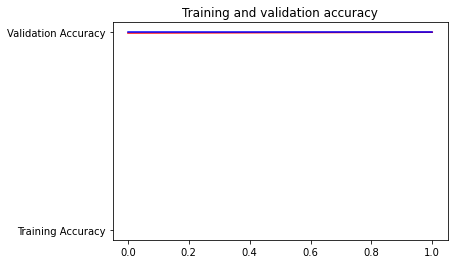

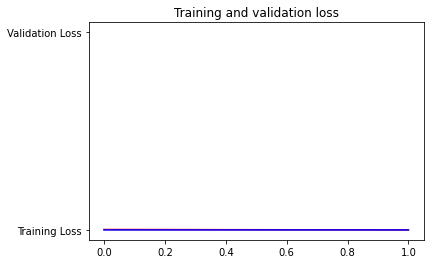

<Figure size 432x288 with 0 Axes>

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=./la_logs --port=6006

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [ ]:
y_pred = model.predict(X_test)

array([[[1.4022856e-09, 1.0000000e+00],
        [5.9620438e-12, 1.0000000e+00],
        [2.5280878e-12, 1.0000000e+00],
        ...,
        [2.5074287e-12, 1.0000000e+00],
        [2.5074287e-12, 1.0000000e+00],
        [2.5074287e-12, 1.0000000e+00]],

       [[1.4159443e-09, 1.0000000e+00],
        [6.0007420e-12, 1.0000000e+00],
        [2.5476971e-12, 1.0000000e+00],
        ...,
        [2.5228999e-12, 1.0000000e+00],
        [2.5228999e-12, 1.0000000e+00],
        [2.5228999e-12, 1.0000000e+00]],

       [[1.4112959e-09, 1.0000000e+00],
        [5.9817724e-12, 1.0000000e+00],
        [2.5369999e-12, 1.0000000e+00],
        ...,
        [2.5121151e-12, 1.0000000e+00],
        [2.5121151e-12, 1.0000000e+00],
        [2.5121151e-12, 1.0000000e+00]],

       ...,

       [[1.3968480e-09, 1.0000000e+00],
        [5.9486860e-12, 1.0000000e+00],
        [2.5237759e-12, 1.0000000e+00],
        ...,
        [2.5269259e-12, 1.0000000e+00],
        [2.5269259e-12, 1.0000000e+00],
        [

In [ ]:
y_pred = y_pred= y_pred.argmax(axis=-1)
y_pred

0

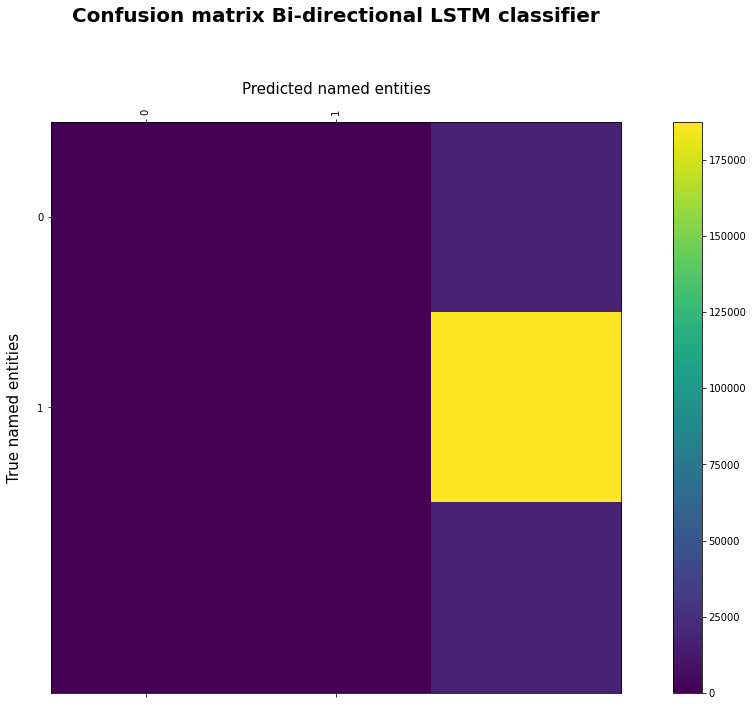

In [ ]:
from sklearn.metrics import confusion_matrix

y_test = np.array(y_test).flatten()
y_pred = y_pred.flatten()
cm = confusion_matrix(y_test, y_pred)

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted named entities', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True named entities', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(2), [0,1], rotation=90)
plt.yticks(range(2), [0,1])
plt.show()

In [ ]:
from sklearn.metrics import classification_report
sentiment_vocab = ['M', 'W']

report = classification_report(y_test, y_pred_binary, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:2]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

ValueError: Found input variables with inconsistent numbers of samples: [224000, 0]